<a href="https://colab.research.google.com/github/CodeEasy-5MD/Dolphinemuthoni/blob/main/CLASSIFICATION_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras #High level API
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.utils import to_categorical #integer label - one-hot encoding for multi-class classification


# Data Generation - Generate synthetic data to use

In [ ]:
# process of generating synthetic data
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 10000

# print to generate 10,000 soil samples
print(f"Generating {n_samples} synthetic soil samples...")

# Create synthetic numeric and categorical data with dictionary
# use poisson distribution for count data
# use random normal for non-count data
#use gamma for positive skew, beta for negative(percentages)
data = {
    'site_id': range(n_samples),
    'earthworms': np.random.poisson(10, n_samples),
    'springtails': np.random.poisson(15, n_samples),
    'mites': np.random.poisson(20, n_samples),
    'nematodes': np.random.poisson(50, n_samples),
    'ph': np.random.normal(6.5, 1.5, n_samples),
    'organic_matter': np.random.gamma(2, 2, n_samples),
    'lead_concentration': np.random.exponential(2, n_samples),
    'cadmium_concentration': np.random.exponential(0.5, n_samples),
    'nitrogen': np.random.normal(20, 5, n_samples),
    'phosphorus': np.random.normal(15, 3, n_samples),
    'potassium': np.random.normal(25, 6, n_samples),
    'temperature': np.random.normal(15, 5, n_samples),
    'moisture': np.random.beta(2, 3, n_samples) * 100,
    # Additional categorical features
    'soil_type': np.random.choice(['clay', 'sand', 'loam', 'silt'], n_samples,
                                 p=[0.25, 0.3, 0.35, 0.1]),
    'land_use': np.random.choice(['agricultural', 'forest', 'urban', 'industrial'], n_samples,
                                p=[0.4, 0.3, 0.2, 0.1]),
    'climate_zone': np.random.choice(['temperate', 'tropical', 'arid', 'continental'], n_samples,
                                   p=[0.3, 0.25, 0.2, 0.25])
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Ensure realistic bounds for certain variables
# limit range of values
df['ph'] = np.clip(df['ph'], 3.0, 10.0)  # pH should be between 3-10
df['organic_matter'] = np.clip(df['organic_matter'], 0.1, 15.0)  # Reasonable organic matter range
df['nitrogen'] = np.clip(df['nitrogen'], 5, 50)  # Reasonable nitrogen range
df['phosphorus'] = np.clip(df['phosphorus'], 5, 40)  # Reasonable phosphorus range
df['potassium'] = np.clip(df['potassium'], 10, 60)  # Reasonable potassium range
df['temperature'] = np.clip(df['temperature'], -5, 35)  # Reasonable temperature range
df['moisture'] = np.clip(df['moisture'], 5, 95)  # Moisture percentage

# Create realistic toxicity score with multiple influencing factors and noise
def calculate_toxicity_score(row):
    # Base toxicity from heavy metals and pH
    # the numbers are the weights produced by code above
    # these indicate environmental factors essential to determine soil health
    base_score = (
        row['lead_concentration'] * 2 + # 2 is toxic but less immediately
        row['cadmium_concentration'] * 5 + # higly toxic even in small amounts
        np.maximum(0, 8 - row['ph']) * 3 + # only penalizes acidic soils
        (row['earthworms'] < 5) * 4 + # indicators species, loss indicates poor soil health
        (row['organic_matter'] < 2) * 3 # low organic matter indicates potentially contaminated soils
    )

    # Additional realistic factors that affect soil toxicity
    additional_factors = (
        # High nitrogen can indicate contamination
        (row['nitrogen'] > 35) * 2 +
        # Very low phosphorus might indicate poor soil health
        (row['phosphorus'] < 8) * 1.5 +
        # Extreme temperatures affect soil biology
        (abs(row['temperature'] - 15) > 15) * 1 +
        # Very low or high moisture affects toxicity
        ((row['moisture'] < 15) or (row['moisture'] > 80)) * 1.5 +
        # Industrial land use increases contamination risk
        (row['land_use'] == 'industrial') * 3 +
        # Urban areas tend to have more contamination
        (row['land_use'] == 'urban') * 1.5 +
        # Clay soil can trap more contaminants
        (row['soil_type'] == 'clay') * 1 +
        # Arid climate can concentrate salts and toxins
        (row['climate_zone'] == 'arid') * 1
    )

    # Add realistic measurement noise (simulating lab variability)
    # noise is to cater for real world dynamism - simulates real world dynamics
    noise = np.random.normal(0, 1.5)

    # Combine all factors
    total_score = base_score + additional_factors + noise

    return max(0, total_score)

# Calculate toxicity scores
print("Calculating toxicity scores based on environmental factors...")
df['toxicity_score'] = df.apply(calculate_toxicity_score, axis=1)

# Create categorical toxicity levels

toxicity_bins = [0, 6, 12, 20, np.inf] #values indicating criticality. Bins are thresholds used to categorize continuous values to discrete levels.
toxicity_labels = ['Low', 'Medium', 'High', 'Critical']

# create column 'target column'
df['target_column'] = pd.cut(df['toxicity_score'], #toxicity score being the continous variable whereas categorical score is the toxicity labels
                            bins=toxicity_bins,
                            labels=toxicity_labels,
                            include_lowest=True)

# Remove the intermediate toxicity_score column (simulate real-world scenario)
df = df.drop('toxicity_score', axis=1)

# Show data distribution
# part of data exploration
print("\nData Generation Summary:")
print(f"Total samples: {len(df)}")
print(f"Features: {len(df.columns) - 1}")  # Excluding target column

# part of data exploration
print("\nTarget column distribution:")
target_counts = df['target_column'].value_counts().sort_index()
for level, count in target_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{level}: {count} samples ({percentage:.1f}%)")

# Show feature statistics
print("\nFeature ranges:")
numeric_cols = ['earthworms', 'springtails', 'mites', 'nematodes', 'ph', 'organic_matter',
                'lead_concentration', 'cadmium_concentration', 'nitrogen', 'phosphorus',
                'potassium', 'temperature', 'moisture']

# iterates through every column
for col in numeric_cols:
    if col in df.columns:
        print(f"{col}: {df[col].min():.2f} - {df[col].max():.2f} (mean: {df[col].mean():.2f})")

# Save to CSV
df.to_csv('soil_fauna_chemical_data.csv', index=False)

print(f"\nCSV file 'soil_fauna_chemical_data.csv' has been created successfully!")
print("Ready for model training pipeline.")

print("Shape of the DataFrame:")
print(df.shape)
df.head()

Generating 10000 synthetic soil samples...
Calculating toxicity scores based on environmental factors...

Data Generation Summary:
Total samples: 10000
Features: 17

Target column distribution:
Low: 1112 samples (11.1%)
Medium: 3279 samples (32.8%)
High: 4057 samples (40.6%)
Critical: 1552 samples (15.5%)

Feature ranges:
earthworms: 1.00 - 24.00 (mean: 10.02)
springtails: 2.00 - 31.00 (mean: 14.95)
mites: 4.00 - 40.00 (mean: 20.04)
nematodes: 25.00 - 78.00 (mean: 49.93)
ph: 3.00 - 10.00 (mean: 6.51)
organic_matter: 0.10 - 15.00 (mean: 4.02)
lead_concentration: 0.00 - 22.91 (mean: 2.06)
cadmium_concentration: 0.00 - 4.41 (mean: 0.50)
nitrogen: 5.00 - 39.82 (mean: 19.96)
phosphorus: 5.00 - 25.71 (mean: 15.01)
potassium: 10.00 - 50.79 (mean: 25.06)
temperature: -2.67 - 33.99 (mean: 15.03)
moisture: 5.00 - 95.00 (mean: 39.75)

CSV file 'soil_fauna_chemical_data.csv' has been created successfully!
Ready for model training pipeline.
Shape of the DataFrame:
(10000, 18)


,site_id,earthworms,springtails,mites,nematodes,ph,organic_matter,lead_concentration,cadmium_concentration,nitrogen,phosphorus,potassium,temperature,moisture,soil_type,land_use,climate_zone,target_column
0,0,12,22,12,46,6.952968,12.129065,3.924232,0.054944,18.649620,11.855487,23.513594,16.738475,20.578496,loam,urban,continental,High
1,1,6,19,15,64,5.974926,1.911948,6.247633,0.414751,11.719311,13.976889,27.693435,7.448194,24.965665,clay,agricultural,tropical,Critical
2,2,11,19,29,50,8.708865,1.950916,1.951511,0.083560,23.246353,17.776257,31.667013,15.427302,52.325986,sand,forest,temperate,Medium
3,3,14,17,19,53,7.295931,1.023322,0.808252,0.539989,19.549403,8.996310,25.646576,20.608325,54.887700,sand,urban,continental,High
4,4,7,20,20,50,3.893329,2.381067,0.737681,0.575804,19.726727,14.405089,34.656344,14.231548,24.122126,sand,forest,tropical,High


# Data Preprocessing

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# _ _ _ _ _ _ _ _
# 1. DATA PREPROCESSING FOR NEURAL NETWORKS
# _ _ _ _ _ _ _ _ _ _

# Define class
class SoilDataProcessor:
    def __init__(self): # constructor to initialize class instance
        self.scaler = StandardScaler() # normalize numerical features
        self.label_encoder = LabelEncoder() # convert categorical target labels to numerical values
        self.feature_names = None # iniialize variable to store names of processed features
        self.n_classes = None # iniialize variable o store unique classes in targe variable


    # Get to data processing method
    # Parameters would be: Input dataframe, target_column, test & val size
    def clean_and_prepare_data(self, df, target_column, test_size=0.2, val_size=0.2):

       """
        Comprehensive data preparation for neural networks
        """
       print("=== DATA PREPROCESSING ===")

       # Data cleaning
       # Remove duplicates and empty rows
       df_clean = df.drop_duplicates().dropna(how='all') #how=all drops only if all values are NaN
       print(f"Dataset shape after cleaning: {df_clean.shape}")

       # Handle missing values
       df_clean = self._check_missing_values(df_clean, target_column)
       print(f"Dataset shape after missing values: {df_clean.shape}")

       # Separate features and target
       # create feature matrix X
       # create target vector y
       # model should not see answer while learning
       X = df_clean.drop([target_column], axis=1) #remove target column
       y = df_clean[target_column] #keep target column

       # Remove site_id if it exists (not useful for prediction)
       if 'site_id' in X.columns:
           X = X.drop('site_id', axis=1)

      # FEATURE TYPE ANALYSIS
      # Handle different types of data
       numeric_columns = X.select_dtypes(include=[np.number]).columns #identify columns with numeric dtype
       categorical_columns = X.select_dtypes(include=['object']).columns #idetify columns with categorical data
       print(f"Numeric features: {len(numeric_columns)}")
       print(f"Categorical features: {len(categorical_columns)}")
       # CATEGORICAL FEATURE PROCESSING
       # Handle categorical features (one-hot encoding)

       if len(categorical_columns) > 0: # check to see if categorical feature exists
           X_categorical = pd.get_dummies(X[categorical_columns], prefix=categorical_columns) #one hot encode
           X_processed = pd.concat([X[numeric_columns], X_categorical], axis=1) #join the numeric columns & newly one-hot encoded columns
       else:
           X_processed = X[numeric_columns] #if no categorical column just set numeric columns

       self.feature_names = X_processed.columns.tolist()

       # TARGET VARIABLE PROCESSING
       # Encode target variable
       y_encoded = self.label_encoder.fit_transform(y) # convert categorical data to numericals
       self.n_classes = len(np.unique(y_encoded)) #return unique class labels, count and store

       print(f"Number of classes: {self.n_classes}")
       print(f"Classes: {self.label_encoder.classes_}")

       # Show class distribution
       unique, counts = np.unique(y_encoded, return_counts=True)
       for i, (class_idx, count) in enumerate(zip(unique, counts)):
           class_name = self.label_encoder.classes_[class_idx]
           percentage = (count / len(y_encoded)) * 100
           print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

      # Split the data
       X_train, X_temp, y_train, y_temp = train_test_split(
            X_processed, y_encoded, test_size=test_size+ val_size,
            random_state=42, stratify=y_encoded
        )

       val_size_adjusted = val_size / (test_size + val_size)
       X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=1 - val_size_adjusted,
            random_state=42, stratify=y_temp
        )

        # Scale features
       X_train_scaled = self.scaler.fit_transform(X_train)
       X_val_scaled = self.scaler.transform(X_val)
       X_test_scaled = self.scaler.transform(X_test)

       # Convert to categorical for neural network (one-hot encoding for target)
       y_train_cat = to_categorical(y_train, num_classes=self.n_classes)
       y_val_cat = to_categorical(y_val, num_classes=self.n_classes)
       y_test_cat = to_categorical(y_test, num_classes=self.n_classes)

       print(f"Training set: {X_train_scaled.shape}")
       print(f"Validation set: {X_val_scaled.shape}")
       print(f"Test set: {X_test_scaled.shape}")

       return (X_train_scaled, X_val_scaled, X_test_scaled,
                y_train_cat, y_val_cat, y_test_cat,
                y_train, y_val, y_test)  # Keep original labels for evaluation



    # Missing values handling method
    def _check_missing_values(self, df, target_column):
        """Internal method to handle missing values."""
        # Identify columns with missing values, excluding the target
        cols_with_missing = df.columns[df.isnull().any()].tolist()
        if target_column in cols_with_missing:
            cols_with_missing.remove(target_column)

        if not cols_with_missing:
            print("No missing values to handle.")
            return df

        print(f"Handling missing values in columns: {cols_with_missing}")

        # Separate columns for imputation
        numeric_cols_missing = df[cols_with_missing].select_dtypes(include=np.number).columns
        categorical_cols_missing = df[cols_with_missing].select_dtypes(include='object').columns

        # Impute numeric columns with the median
        # Why use imputer
        if len(numeric_cols_missing) > 0:
            numeric_imputer = SimpleImputer(strategy='median')
            df[numeric_cols_missing] = numeric_imputer.fit_transform(df[numeric_cols_missing])
            print(f"  Imputed numeric missing values with median.")

        # Impute categorical columns with the most frequent value
        # Why use impute
        if len(categorical_cols_missing) > 0:
            categorical_imputer = SimpleImputer(strategy='most_frequent')
            df[categorical_cols_missing] = categorical_imputer.fit_transform(df[categorical_cols_missing])
            print(f"  Imputed categorical missing values with most frequent.")

        # df_numeric_imputed = pd.DataFrame(numeric_imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)
        # df_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(df[categorical_cols]), columns=categorical_cols)

        return df


In [ ]:
processor = SoilDataProcessor()
X_train_scaled, X_val_scaled, X_test_scaled,y_train_cat, y_val_cat, y_test_cat, y_train, y_val, y_test = processor.clean_and_prepare_data(df, 'target_column')



=== DATA PREPROCESSING ===
Dataset shape after cleaning: (10000, 18)
No missing values to handle.
Dataset shape after missing values: (10000, 18)
Numeric features: 13
Categorical features: 3
Number of classes: 4
Classes: ['Critical' 'High' 'Low' 'Medium']
  Critical: 1552 samples (15.5%)
  High: 4057 samples (40.6%)
  Low: 1112 samples (11.1%)
  Medium: 3279 samples (32.8%)
Training set: (6000, 25)
Validation set: (2000, 25)
Test set: (2000, 25)


In [ ]:
X_train_scaled


array([[ 0.93785693, -1.53388112,  1.33437834, ...,  1.70851022,
        -0.65699256, -0.56811207],
       [-0.32503744, -1.01488903, -0.00390332, ...,  1.70851022,
        -0.65699256, -0.56811207],
       [ 0.62213334,  0.54208724,  1.33437834, ...,  1.70851022,
        -0.65699256, -0.56811207],
       ...,
       [ 0.62213334, -0.2364009 , -0.67304415, ..., -0.58530525,
         1.52208725, -0.56811207],
       [-0.64076103, -1.01488903,  0.66523751, ..., -0.58530525,
         1.52208725, -0.56811207],
       [-0.95648463, -2.05287322, -0.44999721, ..., -0.58530525,
        -0.65699256, -0.56811207]])

In [ ]:
# check for shape under drop.duplicates() function
df.shape

(10000, 18)

In [ ]:
# check to see if target column dropped
X = df.drop(['target_column'], axis=1)
y = df['target_column']
X.head()

,site_id,earthworms,springtails,mites,nematodes,ph,organic_matter,lead_concentration,cadmium_concentration,nitrogen,phosphorus,potassium,temperature,moisture,soil_type,land_use,climate_zone
0,0,12,22,12,46,6.952968,12.129065,3.924232,0.054944,18.649620,11.855487,23.513594,16.738475,20.578496,loam,urban,continental
1,1,6,19,15,64,5.974926,1.911948,6.247633,0.414751,11.719311,13.976889,27.693435,7.448194,24.965665,clay,agricultural,tropical
2,2,11,19,29,50,8.708865,1.950916,1.951511,0.083560,23.246353,17.776257,31.667013,15.427302,52.325986,sand,forest,temperate
3,3,14,17,19,53,7.295931,1.023322,0.808252,0.539989,19.549403,8.996310,25.646576,20.608325,54.887700,sand,urban,continental
4,4,7,20,20,50,3.893329,2.381067,0.737681,0.575804,19.726727,14.405089,34.656344,14.231548,24.122126,sand,forest,tropical


In [ ]:
# check to see if site_id dropped
X = X.drop('site_id', axis=1)
X.head()

,earthworms,springtails,mites,nematodes,ph,organic_matter,lead_concentration,cadmium_concentration,nitrogen,phosphorus,potassium,temperature,moisture,soil_type,land_use,climate_zone
0,12,22,12,46,6.952968,12.129065,3.924232,0.054944,18.649620,11.855487,23.513594,16.738475,20.578496,loam,urban,continental
1,6,19,15,64,5.974926,1.911948,6.247633,0.414751,11.719311,13.976889,27.693435,7.448194,24.965665,clay,agricultural,tropical
2,11,19,29,50,8.708865,1.950916,1.951511,0.083560,23.246353,17.776257,31.667013,15.427302,52.325986,sand,forest,temperate
3,14,17,19,53,7.295931,1.023322,0.808252,0.539989,19.549403,8.996310,25.646576,20.608325,54.887700,sand,urban,continental
4,7,20,20,50,3.893329,2.381067,0.737681,0.575804,19.726727,14.405089,34.656344,14.231548,24.122126,sand,forest,tropical


In [ ]:
# code to check for the following:
#1. df shape after dropping duplicates ad checking missing values
#2. Columns in dataset with numeric and categorical features
#3. Class distribution(no. of classes, types of classes, percentage distribution) - helps detect class imbalance
processor = SoilDataProcessor()
processor.clean_and_prepare_data(df, 'target_column')
print(processor.feature_names)
print(processor.n_classes)
# sns.histplot(data=df,  kde=True)

=== DATA PREPROCESSING ===
Dataset shape after cleaning: (10000, 18)
No missing values to handle.
Dataset shape after missing values: (10000, 18)
Numeric features: 13
Categorical features: 3
Number of classes: 4
Classes: ['Critical' 'High' 'Low' 'Medium']
  Critical: 1552 samples (15.5%)
  High: 4057 samples (40.6%)
  Low: 1112 samples (11.1%)
  Medium: 3279 samples (32.8%)
Training set: (6000, 25)
Validation set: (2000, 25)
Test set: (2000, 25)
['earthworms', 'springtails', 'mites', 'nematodes', 'ph', 'organic_matter', 'lead_concentration', 'cadmium_concentration', 'nitrogen', 'phosphorus', 'potassium', 'temperature', 'moisture', 'soil_type_clay', 'soil_type_loam', 'soil_type_sand', 'soil_type_silt', 'land_use_agricultural', 'land_use_forest', 'land_use_industrial', 'land_use_urban', 'climate_zone_arid', 'climate_zone_continental', 'climate_zone_temperate', 'climate_zone_tropical']
4


KeyboardInterrupt: 

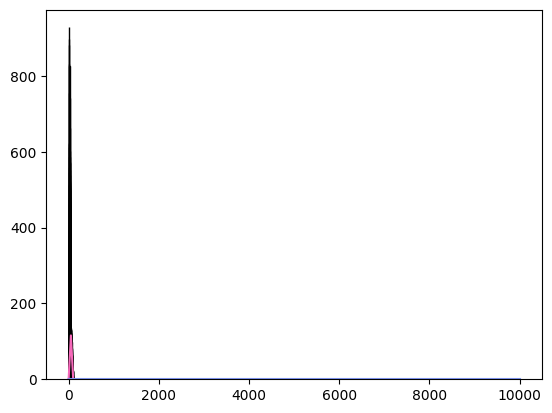

In [ ]:
# sns.histplot(data=df,  kde=True)

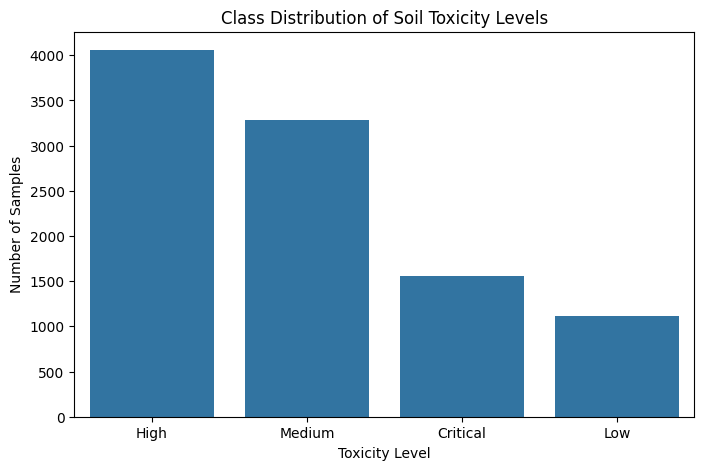

In [ ]:
# plotting class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='target_column', order=df['target_column'].value_counts().index)
plt.title("Class Distribution of Soil Toxicity Levels")
plt.xlabel("Toxicity Level")
plt.ylabel("Number of Samples")
plt.show()

In [ ]:
# code to test correlation matrix
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Neural Network - train, test, validate

In [ ]:
# create custom class SoilToxicityNeuralNetwork()
class SoilToxicityNeuralNetwork:
    def __init__(self, input_dim, n_classes): #python constructor
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.model = None
        self.history = None

    # define method
    # sequential
    def create_basic_model(self, hidden_layers=[128, 64, 32], dropout_rate=0.3, l2_reg=0.001):
        """
        Create a basic feedforward neural network
        """
        # initialize model
        model = keras.Sequential([
            layers.Input(shape=(self.input_dim,)) # define keras input layer constructor
        ])

        # Add hidden layers with dropout and L2 regularization
        for i, units in enumerate(hidden_layers): #iterate through the hidden layers
            model.add(layers.Dense(
                units,
                activation='relu',
                kernel_regularizer=regularizers.l2(l2_reg),
                name=f'hidden_{i+1}'
            ))
            model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}')) # add dropout layer after every dense layer

         # Create Output layer
        model.add(layers.Dense(self.n_classes, activation='softmax', name='output')) #add final layer


        #prepare model for training
        model.compile(
            optimizer='adam', #-adjust learning rate
            loss='categorical_crossentropy', #- multi-class loss function
            metrics=['accuracy'] #-track accuracy during training & validation
        )
        self.model = model
        return model


    def create_callbacks(self, patience=100, min_delta=0.001):
        """
        Create training callbacks for better training control
        """
        callbacks_list = [
            # Early stopping
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                min_delta=min_delta,
                restore_best_weights=True,
                verbose=1
            ),

            # Reduce learning rate on plateau
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=patience//2,
                min_lr=1e-7,
                verbose=1
            ),

            # Model checkpointing
            callbacks.ModelCheckpoint(
                'best_soil_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        return callbacks_list

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """
        Train the neural network with callbacks
        """
        print("=== TRAINING NEURAL NETWORK ===")

        callbacks_list = self.create_callbacks()

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test, y_test_original, processor):
        """
        Evaluate the model and generate comprehensive reports
        """
        print("=== MODEL EVALUATION ===")

        # Get predictions
        y_pred_proba = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_test_original, y_pred)

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"\nClassification Report:")
        print(classification_report(y_test_original, y_pred,
                                  target_names=processor.label_encoder.classes_))

        # Confusion Matrix
        cm = confusion_matrix(y_test_original, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=processor.label_encoder.classes_,
                   yticklabels=processor.label_encoder.classes_)
        plt.title('Confusion Matrix - Soil Toxicity Classification')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        return accuracy, y_pred, y_pred_proba

    def plot_training_history(self):
        """
        Plot training history
        """
        if self.history is None:
            print("No training history available. Train the model first.")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def show_predictions_sample(self, X_test, y_test_original, y_pred_proba, processor, n_samples=10):
        """
        Show sample predictions with probabilities
        """
        print(f"\n=== SAMPLE PREDICTIONS ===")

        for i in range(min(n_samples, len(X_test))):
            predicted_class_idx = np.argmax(y_pred_proba[i])
            predicted_class = processor.label_encoder.classes_[predicted_class_idx]
            actual_class = processor.label_encoder.classes_[y_test_original[i]]
            confidence = y_pred_proba[i][predicted_class_idx]

            status = "✓" if predicted_class == actual_class else "✗"

            print(f"Sample {i+1}: {status} Predicted: {predicted_class} (conf: {confidence:.3f}), "
                  f"Actual: {actual_class}")

In [ ]:
soil = SoilToxicityNeuralNetwork(input_dim=X_train_scaled.shape[1], n_classes=processor.n_classes)

In [ ]:
model = soil.create_basic_model()

In [ ]:
soil.train(X_train_scaled, y_train_cat, X_val_scaled, y_val_cat)

=== TRAINING NEURAL NETWORK ===
Epoch 1/100
172/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3966 - loss: 1.4561
Epoch 1: val_accuracy improved from -inf to 0.71200, saving model to best_soil_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4034 - loss: 1.4422 - val_accuracy: 0.7120 - val_loss: 0.8969 - learning_rate: 0.0010
Epoch 2/100
184/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6198 - loss: 0.9745
Epoch 2: val_accuracy improved from 0.71200 to 0.76000, saving model to best_soil_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6202 - loss: 0.9737 - val_accuracy: 0.7600 - val_loss: 0.7484 - learning_rate: 0.0010
Epoch 3/100
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6922 - loss: 0.8352
Epoch 3: val_accuracy improved from 0.76000 to 0.76400, saving model to best_soil_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6921 - loss: 0.8352 - val_accuracy: 0.7640 - val_loss: 0.7045 - learning_rate: 0.0010
Epoch 4/100
183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6958 - loss: 0.7909
Epoch 4: val_accuracy improved from 0.76400 to 0.78700, saving model to best_soil_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6959 - loss: 0.7906 - val_accuracy: 0.7870 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 5/100
171/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7202 - loss: 0.7427
Epoch 5: val_accuracy did not improve from 0.78700
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7204 - loss: 0.7421 - val_accuracy: 0.7830 - val_loss: 0.6498 - learning_rate: 0.0010
Epoch 6/100
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7356 - loss: 0.7065
Epoch 6: val_accuracy did not improve from 0.78700
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7356 - loss: 0.7066 - val_accuracy: 0.7790 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 7/100
175/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7478 - loss: 0.6850
Epoch 7: val_accuracy did not improve from 0.78700
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7474 - loss: 0.6846 - val_accuracy: 0.7815 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 8/100
181/188 ━━

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7661 - loss: 0.6297 - val_accuracy: 0.7940 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 10/100
185/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 0.6209
Epoch 10: val_accuracy did not improve from 0.79400
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7632 - loss: 0.6210 - val_accuracy: 0.7930 - val_loss: 0.5859 - learning_rate: 0.0010
Epoch 11/100
178/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7724 - loss: 0.6142
Epoch 11: val_accuracy did not improve from 0.79400
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7723 - loss: 0.6141 - val_accuracy: 0.7840 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 12/100
182/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7678 - loss: 0.6038
Epoch 12: val_accuracy did not improve from 0.79400
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7678 - loss: 0.6038 - val_accuracy: 0.7935 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 13/100
173

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8008 - loss: 0.5350 - val_accuracy: 0.7990 - val_loss: 0.5344 - learning_rate: 0.0010
Epoch 24/100
176/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.5318
Epoch 24: val_accuracy did not improve from 0.79900
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7989 - loss: 0.5321 - val_accuracy: 0.7935 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 25/100
183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.5349
Epoch 25: val_accuracy did not improve from 0.79900
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8008 - loss: 0.5351 - val_accuracy: 0.7905 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 26/100
180/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.5191
Epoch 26: val_accuracy did not improve from 0.79900
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8037 - loss: 0.5197 - val_accuracy: 0.7915 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 27/100
173

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8030 - loss: 0.5228 - val_accuracy: 0.7995 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 28/100
184/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8001 - loss: 0.5205
Epoch 28: val_accuracy did not improve from 0.79950
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8001 - loss: 0.5206 - val_accuracy: 0.7985 - val_loss: 0.5307 - learning_rate: 0.0010
Epoch 29/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8119 - loss: 0.5173
Epoch 29: val_accuracy did not improve from 0.79950
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8118 - loss: 0.5174 - val_accuracy: 0.7960 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 30/100
183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8148 - loss: 0.5083
Epoch 30: val_accuracy did not improve from 0.79950
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8146 - loss: 0.5086 - val_accuracy: 0.7925 - val_loss: 0.5310 - learning_rate: 0.0010
Epoch 31/100
174

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8093 - loss: 0.5103 - val_accuracy: 0.8045 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 32/100
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8113 - loss: 0.5048
Epoch 32: val_accuracy improved from 0.80450 to 0.80500, saving model to best_soil_model.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8113 - loss: 0.5049 - val_accuracy: 0.8050 - val_loss: 0.5288 - learning_rate: 0.0010
Epoch 33/100
173/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8118 - loss: 0.5088
Epoch 33: val_accuracy did not improve from 0.80500
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8111 - loss: 0.5092 - val_accuracy: 0.7995 - val_loss: 0.5249 - learning_rate: 0.0010
Epoch 34/100
182/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.5081
Epoch 34: val_accuracy did not improve from 0.80500
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8084 - loss: 0.5082 - val_accuracy: 0.7965 - val_loss: 0.5253 - learning_rate: 0.0010
Epoch 35/100
171/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8138 - loss: 0.5017
Epoch 35: val_accuracy did not improve from 0.80500
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8133 - loss: 0.5026 - val_accuracy: 0.8005 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 36/100
167

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8151 - loss: 0.4912 - val_accuracy: 0.8060 - val_loss: 0.5314 - learning_rate: 0.0010
Epoch 40/100
177/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8155 - loss: 0.4986
Epoch 40: val_accuracy did not improve from 0.80600
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8153 - loss: 0.4990 - val_accuracy: 0.7955 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 41/100
184/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8184 - loss: 0.4946
Epoch 41: val_accuracy did not improve from 0.80600
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8183 - loss: 0.4947 - val_accuracy: 0.7965 - val_loss: 0.5307 - learning_rate: 0.0010
Epoch 42/100
179/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8238 - loss: 0.4903
Epoch 42: val_accuracy did not improve from 0.80600
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8235 - loss: 0.4906 - val_accuracy: 0.8005 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 43/100
178

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8102 - loss: 0.4937 - val_accuracy: 0.8075 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 47/100
183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8101 - loss: 0.4913
Epoch 47: val_accuracy did not improve from 0.80750
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8100 - loss: 0.4917 - val_accuracy: 0.7975 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 48/100
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8251 - loss: 0.4878
Epoch 48: val_accuracy did not improve from 0.80750
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8251 - loss: 0.4878 - val_accuracy: 0.8065 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 49/100
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8178 - loss: 0.4780
Epoch 49: val_accuracy did not improve from 0.80750
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8178 - loss: 0.4781 - val_accuracy: 0.7985 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 50/100
180

=== MODEL EVALUATION ===
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.8115

Classification Report:
              precision    recall  f1-score   support

    Critical       0.85      0.87      0.86       311
        High       0.86      0.81      0.83       811
         Low       0.74      0.74      0.74       223
      Medium       0.76      0.81      0.78       655

    accuracy                           0.81      2000
   macro avg       0.80      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



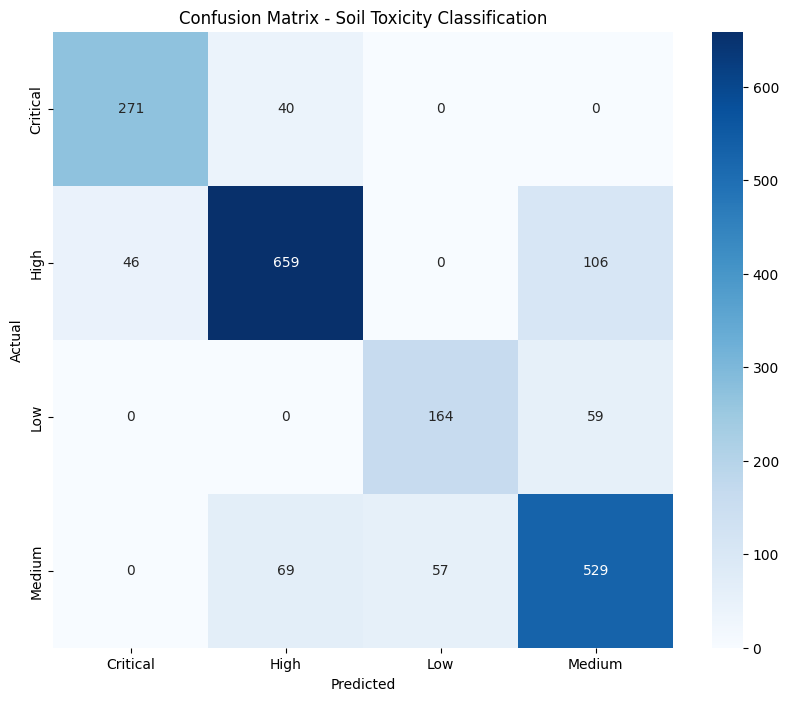

(0.8115,
 array([3, 1, 0, ..., 2, 3, 1]),
 array([[7.5959491e-05, 1.9176397e-01, 1.5204321e-02, 7.9295582e-01],
        [5.6440294e-02, 9.4038546e-01, 1.0953590e-08, 3.1742111e-03],
        [9.8421836e-01, 1.5781673e-02, 1.7366079e-21, 4.7274290e-10],
        ...,
        [1.5358706e-08, 8.3809684e-04, 6.4102340e-01, 3.5813850e-01],
        [5.4658642e-05, 1.1786080e-01, 4.1234840e-02, 8.4084964e-01],
        [1.0361926e-02, 9.4884735e-01, 7.9332740e-06, 4.0782880e-02]],
       dtype=float32))

In [ ]:
soil.evaluate(X_test_scaled, y_test_cat, y_test, processor)

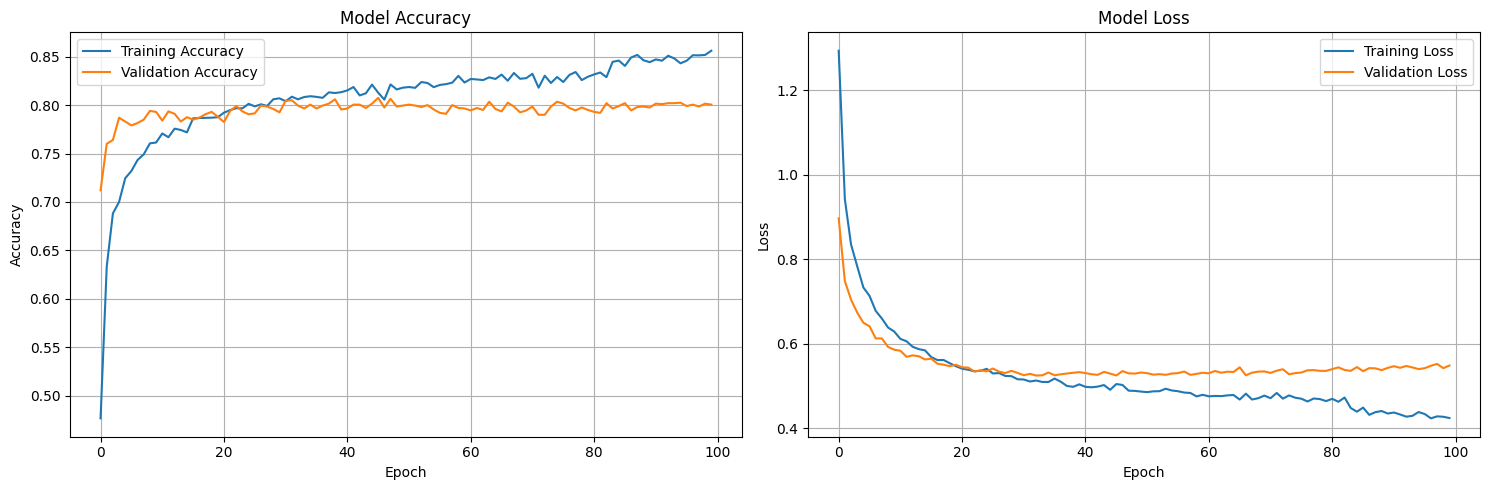

In [ ]:
soil.plot_training_history()